In [ ]:
!nvidia-smi

Tue May 17 12:49:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install modules

In [ ]:
pip install datasets

     |████████████████████████████████| 342 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 212 kB 58.2 MB/s 
     |████████████████████████████████| 136 kB 54.5 MB/s 
     |████████████████████████████████| 127 kB 40.4 MB/s 
     |████████████████████████████████| 271 kB 59.9 MB/s 
     |████████████████████████████████| 144 kB 57.5 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
pip install transformers

     |████████████████████████████████| 4.2 MB 9.0 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from datasets import load_dataset

dataset = load_dataset("xnli",language='vi')

Using custom data configuration default-language=vi


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/default-language=vi/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [ ]:
import pandas as pd

In [ ]:
train=pd.DataFrame(dataset['train'])

In [ ]:
train=train.sample(frac=1)

In [ ]:
len(train)//5

78540

In [ ]:
for i in range(5):
  train_i=train.iloc[i*78540:(i+1)*78540]
  train_i.to_csv(f'/content/drive/MyDrive/vi-nli/raw_dataset/train_{i}.csv',index=False)

In [ ]:
valid=pd.DataFrame(dataset['validation'])

In [ ]:
test=pd.DataFrame(dataset['test'])

In [ ]:
valid.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv",index=False)

In [ ]:
test.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/test.csv",index=False)

#Import modules

In [ ]:
import pandas as pd
import re
import string
from transformers import AutoTokenizer,AutoConfig,AutoModelForSequenceClassification,get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from os.path import join
import os
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm.auto import tqdm
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
name='xlm-roberta-base'
max_length=256

root='/content/drive/MyDrive/vi-nli'
preprocessed_data=join(root,"preprocessed_data")
models=join(root,'models')
model_name=join(models,f'{name}-{max_length}')

In [ ]:
os.makedirs(preprocessed_data, exist_ok=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(name)

#Load dataset

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/vi-nli/raw_dataset/train_0.csv")

In [ ]:
train

,premise,hypothesis,label
0,"Vì vậy , nhưng đó cũng là khoảng thời gian bạn...",Thật khó để trở thành dân sự khi anh bị kẹt ở ...,1
1,Đó có phải là những gì họ có ý nghĩa không ?,Họ có nghĩa là thế này không ?,0
2,Nhưng câu chuyện không thực sự nằm trong quá t...,Quy trình thuốc lá rulemaking đã được chatterb...,1
3,"Sau khi bị tổn thương động đất sớm hơn , ngôi ...",Ngôi đền đã trở thành ngân khố của thành phố s...,0
4,Tôi không đặt mỗi trăm phần trăm cổ phiếu vào ...,Tôi không hoàn toàn tin những gì anh ta đang n...,0
...,...,...,...
78535,Chúng tôi chỉ đang cố gắng nói chuyện của chún...,Chúng tôi đang cố gắng nói chuyện với chúng tô...,2
78536,Vâng à smith đã đi trên khá tốt wright đã được,Smith đã trở nên khủng khiếp .,2
78537,Bây giờ nó sẽ rất đáng sợ .,Đó sẽ là trải nghiệm đáng sợ nhất mà tôi có th...,1
78538,Mọi thứ sẽ đến một điểm mà nó sẽ có thể đến mộ...,Người ta sẽ không cần cảnh sát đâu .,0


In [ ]:
valid=pd.read_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv")
test=pd.read_csv("/content/drive/MyDrive/vi-nli/raw_dataset/test.csv")

##Preprocessing

In [ ]:
punctuations=list(string.punctuation)

In [ ]:
def normalizer(text):

  def remove_meaningless_token(s):
    return re.sub(r'\b(jeez|yeah|uhhuh|uh|oh|huh)\b',' ',s)
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_punctuations(s):
    chs=[]
    for ch in s:
      if ch not in punctuations:
        chs.append(ch)
      else:
        chs.append(" ")
    return "".join(chs)

  return fix_whitespaces(remove_meaningless_token(uncased(remove_punctuations(text)))).strip()

In [ ]:
train['clean_premise']=train['premise'].map(normalizer)

In [ ]:
valid['clean_premise']=valid['premise'].map(normalizer)

In [ ]:
train['clean_hypothesis']=train['hypothesis'].map(normalizer)

In [ ]:
valid['clean_hypothesis']=valid['hypothesis'].map(normalizer)

In [ ]:
def seperate_sentence(s):
  return tokenizer.tokenize(s)

In [ ]:
def get_seq_len(s):
  tokens=seperate_sentence(s)
  return len(tokens)

In [ ]:
train['premise_seq_len']=train['clean_premise'].map(get_seq_len)
train['hypothesis_seq_len']=train['clean_hypothesis'].map(get_seq_len)

In [ ]:
valid['premise_seq_len']=valid['clean_premise'].map(get_seq_len)
valid['hypothesis_seq_len']=valid['clean_hypothesis'].map(get_seq_len)

In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
  ax.bar(x,y)
  fig.show()

In [ ]:
max(train['premise_seq_len'].unique()),max(train['hypothesis_seq_len'].unique())

(440, 86)

In [ ]:
max(valid['premise_seq_len'].unique()),max(valid['hypothesis_seq_len'].unique())

(77, 37)

In [ ]:
min(train['premise_seq_len'].unique()),min(train['hypothesis_seq_len'].unique())

(0, 1)

In [ ]:
min(valid['premise_seq_len'].unique()),min(valid['hypothesis_seq_len'].unique())

(4, 2)

In [ ]:
train=train[~(train['premise_seq_len']==0)]

In [ ]:
train=train[~(train['hypothesis_seq_len']==0)]

In [ ]:
valid[(valid['premise_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [ ]:
valid[(valid['hypothesis_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [ ]:
samples1=train['clean_premise'].tolist()[:100]
samples2=train['clean_hypothesis'].tolist()[:100]
for i in range(100):
  print(samples1[i])
  print(samples2[i])
  print('\n')
  

vì vậy nhưng đó cũng là khoảng thời gian bạn bắt đầu bị sốt cabin
thật khó để trở thành dân sự khi anh bị kẹt ở một nơi với một người khác


đó có phải là những gì họ có ý nghĩa không
họ có nghĩa là thế này không


nhưng câu chuyện không thực sự nằm trong quá trình thuốc lá trong quá trình thực phẩm và quản trị viên ma túy đó là một phần của câu chuyện
quy trình thuốc lá rulemaking đã được chatterbox là mảnh của câu chuyện và là trung tâm trên câu chuyện theo các nhà phê bình


sau khi bị tổn thương động đất sớm hơn ngôi đền được sử dụng như bộ ngân khố capitolium và thành phố
ngôi đền đã trở thành ngân khố của thành phố sau khi bị tổn thương động đất sớm hơn


tôi không đặt mỗi trăm phần trăm cổ phiếu vào những gì anh ta nói nhưng tôi không đặt hàng trăm phần trăm vào những gì
tôi không hoàn toàn tin những gì anh ta đang nòi


thời đại vàng cho xã hội minoan được biết đến với tư cách là kỷ nguyên cung điện mới kéo dài 300 năm
kỷ nguyên cung điện mới đó là thời đại vàng cho xã hội mino

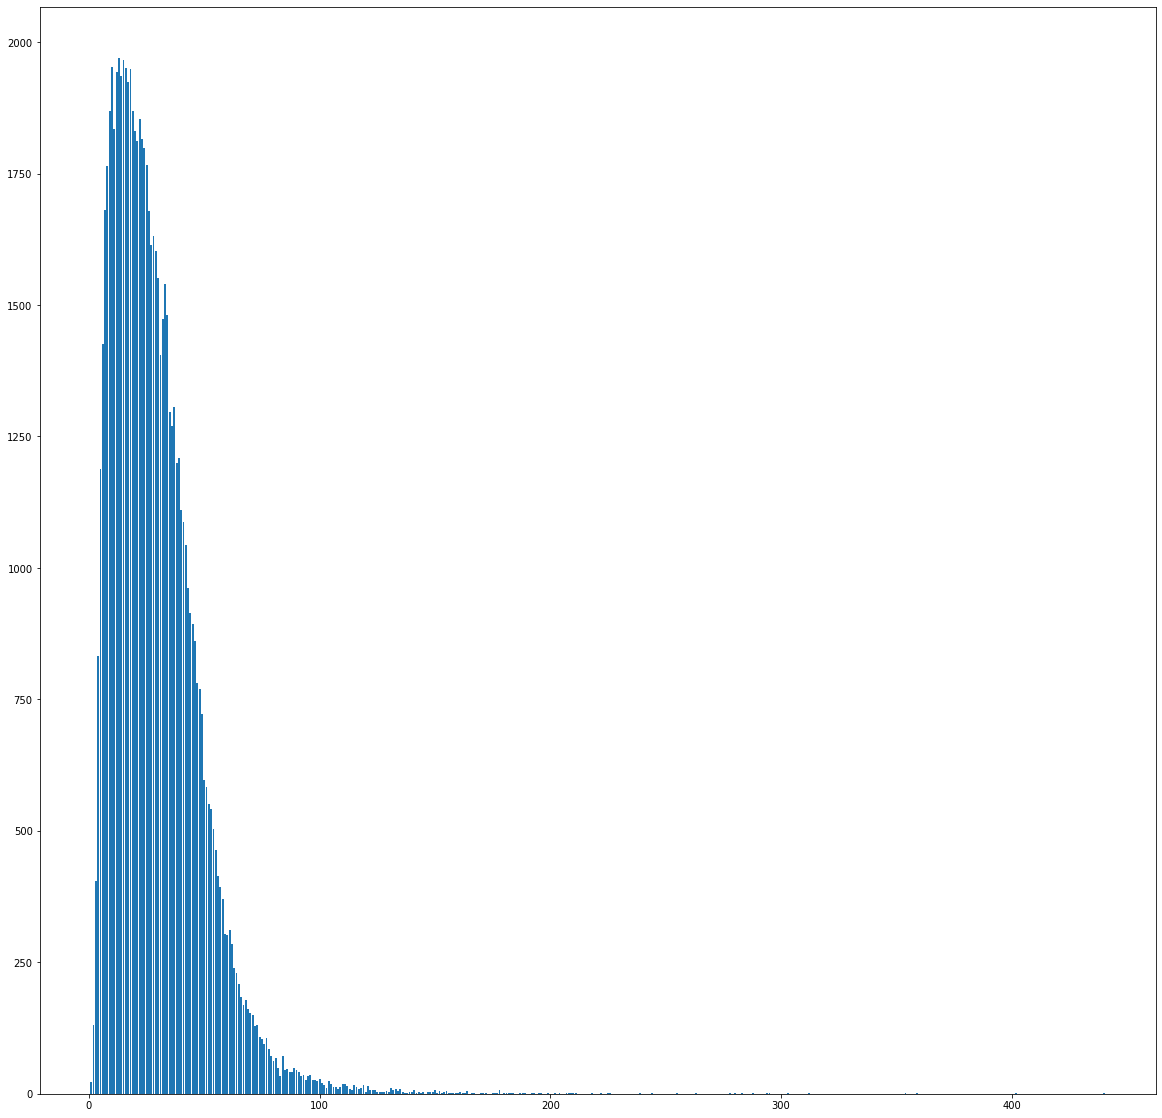

In [ ]:
dict_occurs=train['premise_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

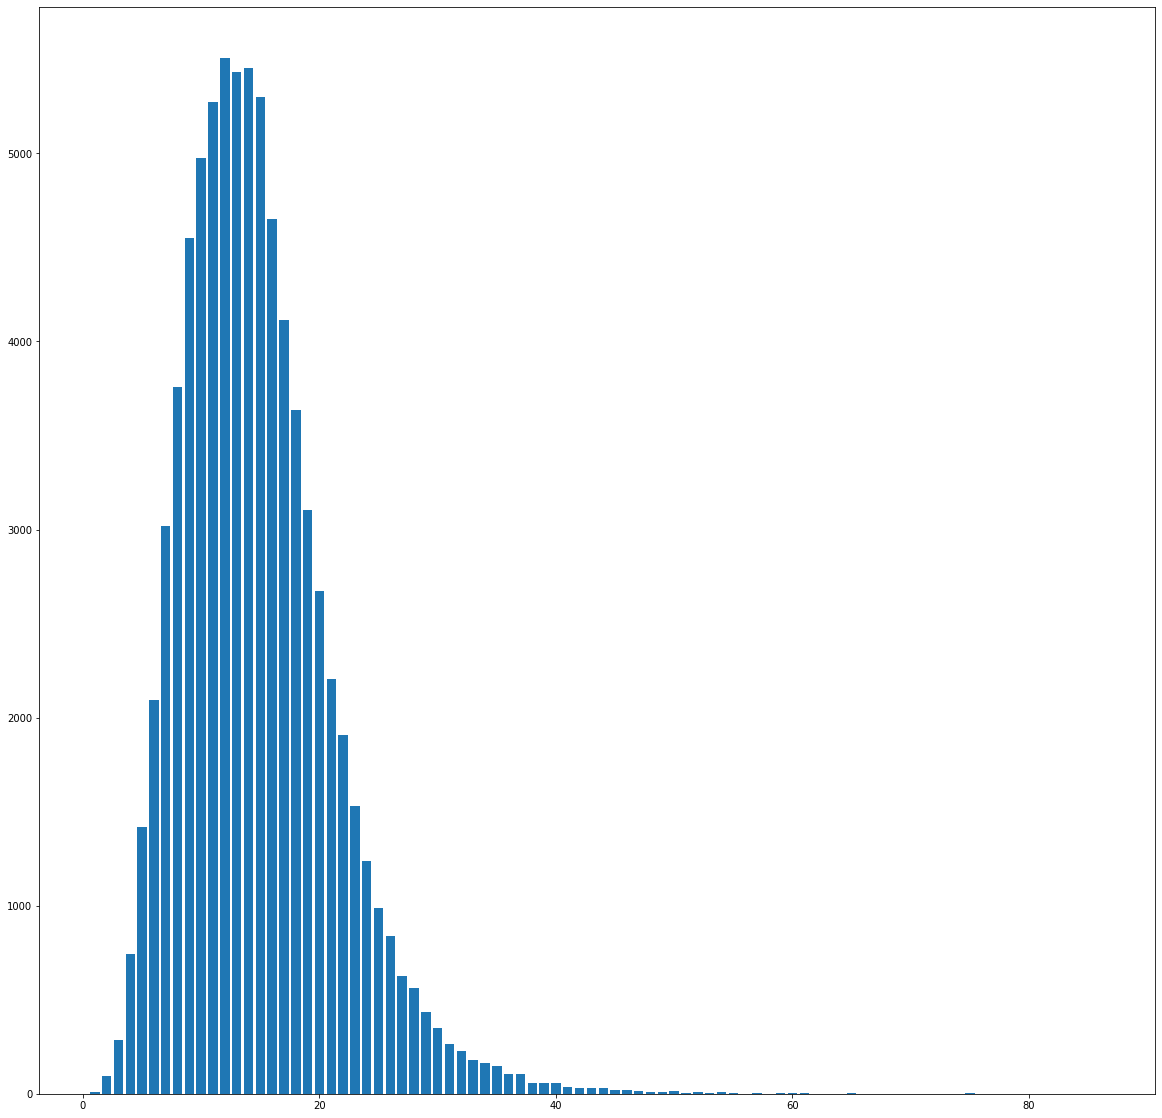

In [ ]:
dict_occurs=train['hypothesis_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

In [ ]:
train['total_seq_len']=train['premise_seq_len']+train['hypothesis_seq_len']

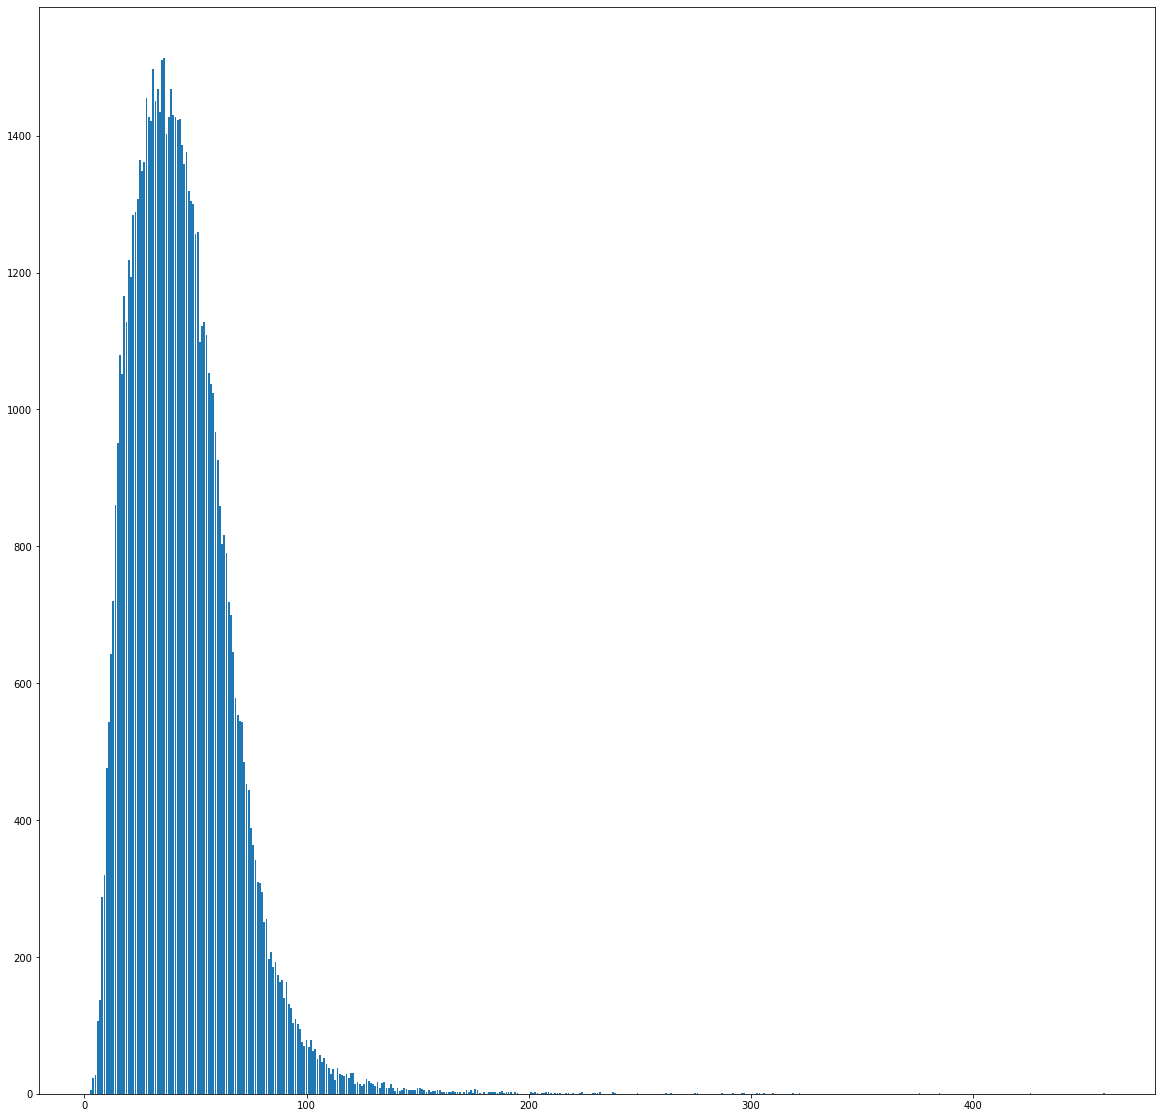

In [ ]:
dict_occurs=train['total_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

assign max length 256

In [ ]:
train.value_counts(['label'])

label
2        26330
1        26043
0        26038
dtype: int64

In [ ]:
valid.value_counts(['label'])

label
0        830
1        830
2        830
dtype: int64

In [ ]:
train.to_csv(join(preprocessed_data,'train_0.csv'),index=False)
valid.to_csv(join(preprocessed_data,'valid.csv'),index=False)

In [ ]:
train

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len,total_seq_len
0,"Vì vậy , nhưng đó cũng là khoảng thời gian bạn...",Thật khó để trở thành dân sự khi anh bị kẹt ở ...,1,vì vậy nhưng đó cũng là khoảng thời gian bạn b...,thật khó để trở thành dân sự khi anh bị kẹt ở ...,17,20,37
1,Đó có phải là những gì họ có ý nghĩa không ?,Họ có nghĩa là thế này không ?,0,đó có phải là những gì họ có ý nghĩa không,họ có nghĩa là thế này không,11,7,18
2,Nhưng câu chuyện không thực sự nằm trong quá t...,Quy trình thuốc lá rulemaking đã được chatterb...,1,nhưng câu chuyện không thực sự nằm trong quá t...,quy trình thuốc lá rulemaking đã được chatterb...,31,28,59
3,"Sau khi bị tổn thương động đất sớm hơn , ngôi ...",Ngôi đền đã trở thành ngân khố của thành phố s...,0,sau khi bị tổn thương động đất sớm hơn ngôi đề...,ngôi đền đã trở thành ngân khố của thành phố s...,25,21,46
4,Tôi không đặt mỗi trăm phần trăm cổ phiếu vào ...,Tôi không hoàn toàn tin những gì anh ta đang n...,0,tôi không đặt mỗi trăm phần trăm cổ phiếu vào ...,tôi không hoàn toàn tin những gì anh ta đang nòi,26,13,39
...,...,...,...,...,...,...,...,...
78535,Chúng tôi chỉ đang cố gắng nói chuyện của chún...,Chúng tôi đang cố gắng nói chuyện với chúng tô...,2,chúng tôi chỉ đang cố gắng nói chuyện của chún...,chúng tôi đang cố gắng nói chuyện với chúng tô...,17,17,34
78536,Vâng à smith đã đi trên khá tốt wright đã được,Smith đã trở nên khủng khiếp .,2,vâng à smith đã đi trên khá tốt wright đã được,smith đã trở nên khủng khiếp,14,8,22
78537,Bây giờ nó sẽ rất đáng sợ .,Đó sẽ là trải nghiệm đáng sợ nhất mà tôi có th...,1,bây giờ nó sẽ rất đáng sợ,đó sẽ là trải nghiệm đáng sợ nhất mà tôi có th...,7,14,21
78538,Mọi thứ sẽ đến một điểm mà nó sẽ có thể đến mộ...,Người ta sẽ không cần cảnh sát đâu .,0,mọi thứ sẽ đến một điểm mà nó sẽ có thể đến mộ...,người ta sẽ không cần cảnh sát đâu,86,8,94


##Create inputs for bert models

In [ ]:
train=pd.read_csv(join(preprocessed_data,'train_0.csv'))
valid=pd.read_csv(join(preprocessed_data,'valid.csv'))

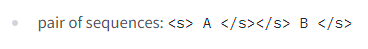

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_mask,labels,device,token_type_ids=None):
        self.labels = labels
        self.input_ids=input_ids
        self.attention_mask=attention_mask
        self.token_type_ids=token_type_ids
        self.device=device
        
    def __len__(self):
            return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        sample = {"inputs":{"input_ids": input_ids.to(self.device),'attention_mask':attention_mask.to(self.device)}, "labels": label.to(self.device)}
        if self.token_type_ids!=None:
          sample['inputs'].update({'token_type_ids':self.token_type_ids[idx].to(self.device)})
        return sample

In [ ]:
train_batch_size=8
num_training_samples=len(train)
num_training_batches=int((num_training_samples/train_batch_size)+0.5)

In [ ]:
valid_batch_size=8
num_valid_samples=len(valid)
num_valid_batches=int((num_valid_samples/valid_batch_size)+0.5)

In [ ]:
return_tensors='pt'

In [ ]:
labels=train['label'].unique().tolist()
labels

[1, 0, 2]

In [ ]:
def create_dataloader(tokenizer,premises,hypothesises,labels,max_length,batch_size,padding=True,truncation=True,return_tensors='pt',device='cpu',drop_last=False):
  x=tokenizer(premises ,hypothesises,padding=padding,truncation=truncation,max_length=max_length,return_tensors=return_tensors)
  y=torch.Tensor(labels).to(torch.long)
  dataset={i:x[i] for i in x}
  dataset.update({"labels":y})
  dataset=ClassificationDataset(**dataset,device=device)
  dataset=DataLoader(dataset,batch_size=batch_size,drop_last=drop_last,shuffle=True)
  return dataset

In [ ]:
train_premises=train['clean_premise'].tolist()[:30000]
train_hypothesises=train['clean_hypothesis'].tolist()[:30000]
train_labels=train['label'].tolist()[:30000]

In [ ]:
train_dataloader=create_dataloader(tokenizer,train_premises,train_hypothesises,train_labels,max_length=max_length,return_tensors=return_tensors,device=device,drop_last=False,batch_size=train_batch_size)

In [ ]:
valid_premises=valid['clean_premise'].tolist()
valid_hypothesises=valid['clean_hypothesis'].tolist()
valid_labels=valid['label'].tolist()

In [ ]:
valid_dataloader=create_dataloader(tokenizer,valid_premises,valid_hypothesises,valid_labels,max_length=max_length,return_tensors=return_tensors,device=device,drop_last=False,batch_size=valid_batch_size)

In [ ]:
for i in train_dataloader:
  print(i['inputs']['input_ids'][0])
  print(i['inputs']['attention_mask'][0])
  break

tensor([    0,   687, 50264,    81, 30342,    18, 15566,  3711,     2,     2,
          687, 26148,  3711,  2059,  4600,   889,  4194,  6051, 19018,  3713,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

#Trainer

In [ ]:
epochs=30
num_training_steps=epochs * len(train_dataloader)
num_warmup_steps=500
init_lr=1e-5
eps =1e-8

In [ ]:
num_training_steps,num_warmup_steps

(112500, 500)

In [ ]:
num_labels=len(labels)
num_labels

3

In [ ]:
classifier_dropout=0.1

In [ ]:
config=AutoConfig.from_pretrained(name)
config.classifier_dropout=classifier_dropout
config.num_labels=num_labels
config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [ ]:
config.save_pretrained(model_name)

In [ ]:
model=AutoModelForSequenceClassification.from_pretrained(name,config=config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
optimizer=torch.optim.AdamW(model.parameters(),lr=init_lr,weight_decay =0.01,eps=eps)

In [ ]:
lr_scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps,)

In [ ]:
def save_model(epoch,model,optimizer,training_loss,valid_loss,path,step=None):
  torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'training_loss': training_loss,
          'valid_loss': valid_loss,
          'step':step
          }, join(path,f'ckpt{epoch}.pt'))

In [ ]:
def run_train(optimizer,dataloader,lr_scheduler):
  model.train(True)
  loop = tqdm(dataloader)
  loss=0
  for batch in dataloader:
    # model.zero_grad(set_to_none=True)
    optimizer.zero_grad()
    inputs=batch['inputs']
    inputs.update({"labels":batch['labels']})
    outputs=model(**inputs)
    # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))
    outputs.loss.backward()

    loss+=outputs.loss.item()
    optimizer.step()
    lr_scheduler.step()
    loop.set_postfix({f'train_loss_per_batch':outputs.loss.item()})
    loop.update()      
    
  return loss/len(dataloader)

In [ ]:
def run_valid(dataloader):
  model.eval()
  loss=0
  with torch.no_grad():
    for batch in dataloader:
      inputs=batch['inputs']
      inputs.update({"labels":batch['labels']})
      outputs=model(**inputs)

      # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))

      loss+=outputs.loss.item()

  return loss/len(dataloader)

In [ ]:
train_loss_per_step=[]
valid_loss_per_step=[]
min_loss=np.inf
count_stopping=np.inf
for epoch in range(1,epochs):
  train_loss=run_train(optimizer,train_dataloader,lr_scheduler)
  valid_loss=run_valid(valid_dataloader)

  train_loss_per_step.append(train_loss)
  valid_loss_per_step.append(valid_loss)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  if valid_loss<min_loss:
    min_loss=valid_loss
    save_model(epoch,model,optimizer,train_loss,valid_loss,model_name)
    count_stopping=0
  else:
    count_stopping+=1
  
  if count_stopping>5:
    break
